**Исследование данных сервиса аренды самокатов GoFast**

Нам предоставлены данные о пользователях сервиса аренды самокатов из нескольких городов и их поездках. Необходимо проанализировать данные и помочь бизнесу развиваться дальше. 
 Пользователи используют мобильное приложение
 - с подпиской
   - абонентская плата 199 рублей в месяц
   - стоимость одной минуты поездки 6 рублей
   - стоимость начала поездки - бесплатно
 - без подписки
   - абонентская плата отсутствует
   - стоимость одной минуты поездки 8 рублей
   - стоимость начала поездки 50 рублей
   
**Цель исследования**
    
  - проанализировать данные
  - проверить гипотезы и сделать заключение для сервиса аренды самокатов
  
**Ход исследования**
    
  - загрузка библиотек и их настройка
  - загрузка и анализ общей информации о каждом датафрейме
  - предобработка (поиск дубликатов и их удаление, изменение типов данных, добавление нового столбца)
  - исследование и обработка и рассчет необходимых метрик сервиса
  - проверка гипотез 
  - выводная часть исследования
  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
from scipy.stats import binom

#### Шаг 1. Загрузка данных

**1.1 Считаем csv-файлы**

In [2]:
users_go = pd.read_csv('/datasets/users_go.csv', sep=',')
rides_go = pd.read_csv('/datasets/rides_go.csv', sep=',')
subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv', sep=',')
pd.set_option('display.max_columns', None)

**1.2 Изучим общую информацию о датафреймах**

In [3]:
users_go.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
users_go.duplicated().sum()

31

In [6]:
users_go['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

In [7]:
users_go.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [8]:
rides_go.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [9]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [10]:
rides_go.duplicated().sum()

0

In [11]:
rides_go.isna().sum()

user_id     0
distance    0
duration    0
date        0
dtype: int64

In [12]:
subscriptions_go.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [13]:
subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


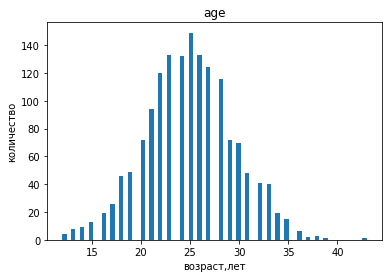

In [14]:
plt.hist(users_go['age'], bins=70)
plt.title('age')
plt.xlabel('возраст,лет')
plt.ylabel('количество')
plt.show()

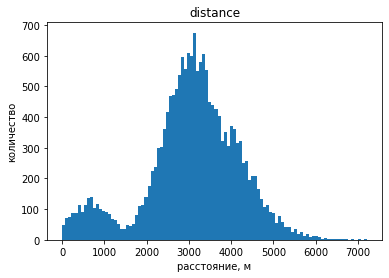

In [15]:
plt.hist(rides_go['distance'], bins=100)
plt.title('distance')
plt.xlabel('расстояние, м')
plt.ylabel('количество')
plt.show()

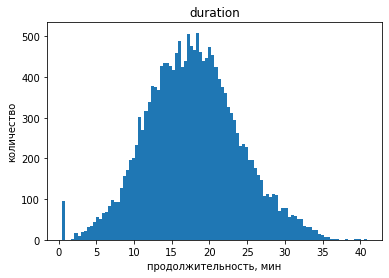

In [16]:
plt.hist(rides_go['duration'], bins=100)
plt.title('duration')
plt.xlabel('продолжительность, мин')
plt.ylabel('количество')
plt.show()

**Вывод**

Наименования столбцов не нуждаются в исправлении.
В первом датафрейме users_go 1565 строк, дубликатов 31, пропусков нет.
Во втором датафрейме rides_go 18068 строк, дубликатов нет, пропусков нет.
В третьем датафрейме subscriptions_go 2 строки, дубликатов нет, пропусков нет.
Необходимо поменять тип данных для некоторых столбцов.

#### Шаг 2. Предобработка данных

***2.1 Приводим столбец date к типу даты pandas***

In [17]:
#изменяем тип столбца date
rides_go['date'] = rides_go['date'].astype('datetime64')
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


***2.2 Создаем новый столбец с номером месяца***

In [18]:
#создаем новый стобец month
rides_go['month'] = rides_go['date'].dt.month
rides_go.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


<AxesSubplot:>

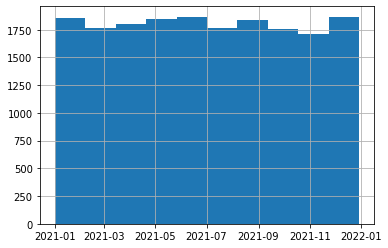

In [19]:
# построим гистограмму по столбцу date
rides_go['date'].hist()

In [20]:
print('Минимальная дата :', rides_go['date'].min())
print('Максимальная дата:', rides_go['date'].max())

Минимальная дата : 2021-01-01 00:00:00
Максимальная дата: 2021-12-30 00:00:00


***2.3 Работа с пропусками и дубликатами***

В представленных датафреймах пропуски в значениях отсутствуют, а дубликаты присутствуют только в users_go. 

In [21]:
users_go['city'].duplicated().sum()

1557

In [22]:
users_go['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

In [23]:
users_go['name'].duplicated().sum()

1371

In [24]:
users_go['name'].unique()

array(['Кира', 'Станислав', 'Алексей', 'Константин', 'Адель', 'Регина',
       'Игорь', 'Юрий', 'Ян', 'Валерий', 'Агата', 'Марк', 'Ева',
       'Антонина', 'Валерия', 'Амалия', 'Даниил', 'Аделина', 'Святогор',
       'Борис', 'Вероника', 'Ростислав', 'Назар', 'Эдуард', 'Василий',
       'Денис', 'Тамара', 'Николай', 'Эвелина', 'Федор', 'Руслан', 'Иван',
       'Любовь', 'Ярослава', 'Майя', 'Ильдар', 'Данила', 'Нина',
       'Стефания', 'Ясмина', 'Дмитрий', 'Александр', 'Одиссей', 'Арсений',
       'Алла', 'Таисия', 'Максим', 'Юлиана', 'Павел', 'Карина', 'Алиса',
       'Лидия', 'Рамиль', 'Родион', 'Ника', 'Оксана', 'Анастасия',
       'Маргарита', 'Вера', 'Тимур', 'Никита', 'Лев', 'Влад', 'Артур',
       'Анна', 'Ольга', 'Вячеслав', 'Ксения', 'Виталина', 'Владислав',
       'Тамерлан', 'Амина', 'Вадим', 'Олеся', 'Зарина', 'Егор', 'Гордей',
       'Лилия', 'Святослав', 'Роберт', 'Амир', 'Влада', 'Богдан',
       'Полина', 'Марат', 'Елисей', 'Макар', 'Алина', 'Глеб', 'Андрей',
       'Ал

In [25]:
users_go['age'].duplicated().sum()

1536

In [26]:
users_go['age'].unique()

array([22, 31, 20, 26, 28, 25, 23, 21, 18, 27, 24, 29, 32, 14, 19, 30, 17,
       12, 35, 33, 13, 15, 37, 16, 34, 38, 36, 39, 43])

In [27]:
users_go.duplicated().sum()

31

In [28]:
users_go = users_go.drop_duplicates()

In [29]:
users_go.duplicated().sum()

0

In [30]:
users_go.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


In [31]:
#в столбце distance  изменим тип данных
rides_go['distance'] = rides_go['distance'].astype('int')

In [32]:
#в столбце duration округляем значение до целого числа в большую сторону, изменим тип данных
rides_go['duration'] = np.ceil(rides_go['duration']).astype('int')

In [33]:
rides_go.info()
rides_go.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  int64         
 2   duration  18068 non-null  int64         
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 705.9 KB


,user_id,distance,duration,date,month
0,1,4409,26,2021-01-01,1
1,1,2617,16,2021-01-18,1
2,1,754,7,2021-04-20,4
3,1,2694,19,2021-08-11,8
4,1,4028,27,2021-08-28,8


**Вывод**

Изменили типы данных в столбцах date, distance, duration.
Создали столбец с номером месяца  на основе столбца date.
Удалили дубликаты в датафрейме users_go.

#### Шаг 3. Исследовательский анализ данных

***3.1 Частота встречаемости городов***

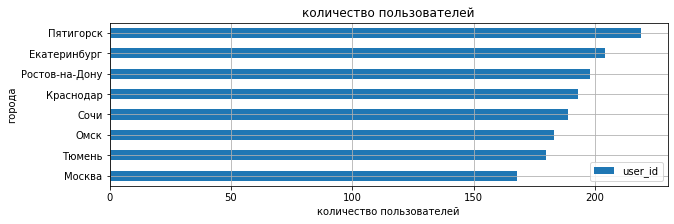

In [34]:
(
    users_go.pivot_table(index='city', values='user_id', aggfunc='count')
    .sort_values(by='user_id', ascending=True).plot(kind='barh', grid=True, figsize=(10,3))
)                                                 
plt.title('количество пользователей')
plt.xlabel('количество пользователей')
plt.ylabel('города')
plt.show()

In [35]:
users_go.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id', ascending=False)

,user_id
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


Визуализация показала что в южных городах используют самокаты чаще чем в северных. Вероятно это связано с более длительным сезоном катаная. Екатеринбург - исключение. 

***3.2 Соотношение пользователей с подпиской и без нее***

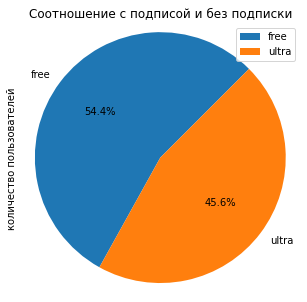

In [36]:
(
    users_go.pivot_table(index='subscription_type', values='user_id', aggfunc='count')
    .plot.pie(y='user_id', figsize=(5,5), label='количество пользователей', autopct='%.1f%%', startangle=45, title='Соотношение с подписой и без подписки')
)
plt.axis('equal')
plt.show()

Из круговой диаграммы видно, что пользователей с подпиской 45.6%, без подписки 54.4%.

In [37]:
subscriptions_go['subscription_type'].describe()

count        2
unique       2
top       free
freq         1
Name: subscription_type, dtype: object

***3.3 Визуализация пользователей по возрасту***

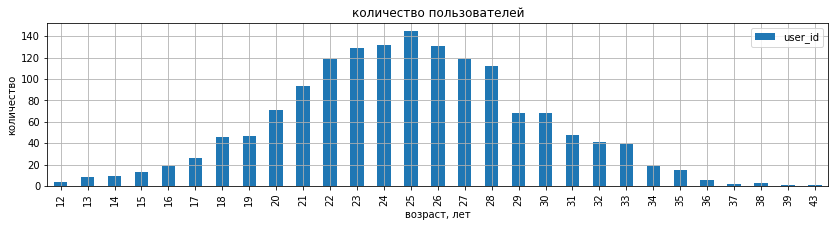

In [38]:
(
    users_go.pivot_table(index='age', values='user_id', aggfunc='count')
    .sort_values(by='age', ascending=True).plot(kind='bar', grid=True, figsize=(14,3))
)                                                 
plt.title('количество пользователей')
plt.xlabel('возраст, лет')
plt.ylabel('количество')
plt.show()

In [39]:
users_go['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

График показывает нормальное распределение пользователей по возрасту. Среднее значение данных близко к медиане.

***3.4 Расстояние одной поездки пользователя***

In [40]:
rides_go['distance'].describe()

count    18068.000000
mean      3070.159841
std       1116.831548
min          0.000000
25%       2542.750000
50%       3133.000000
75%       3776.000000
max       7211.000000
Name: distance, dtype: float64

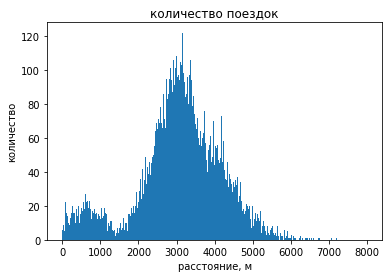

In [41]:
plt.hist(rides_go['distance'], bins=700, range=(1,8000))
plt.title('количество поездок')
plt.xlabel('расстояние, м')
plt.ylabel('количество')
plt.show()

На гистограмме отображено 2 области с нормальным распределением значений в районе 650 и 3100.

***3.5 Визуализация продолжительности поездки пользователя***

In [42]:
rides_go['duration'].describe()

count    18068.000000
mean        18.303520
std          6.094928
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64

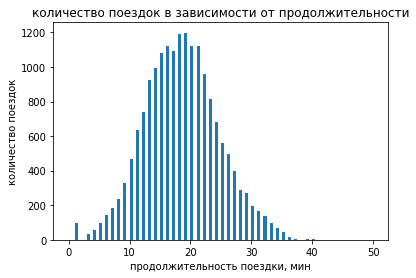

(0.0, 50.0)

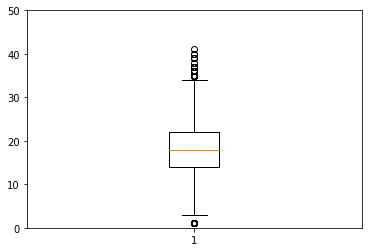

In [43]:
plt.hist(rides_go['duration'], bins=100, range=(0,50))
plt.title('количество поездок в зависимости от продолжительности')
plt.xlabel('продолжительность поездки, мин')
plt.ylabel('количество поездок')
plt.show()
plt.boxplot(rides_go['duration'])
plt.ylim(0, 50)

Продолжительность поездок нормально распределена между значениями 2 и 36. 
Среднее значение времени поездки равно 17 мин, что совпадает с медианой данных.
Есть поездки короткие в 1 мин это связано с поездками на короткие расстояния.

**Вывод**

1. В прокате самокатов первое место занимает курортный город Пятигорск. Екатеринбург  на 2 месте.
2. Пользователей без подписки больше на 20% чем с подпиской - 54,4% и 45,6% соответственно.
3. Распределение пользователей по возрасту по гистограмме указывает что среднее значение данных близко к медиане и находится в районе 25 лет.
4. Большая часть поездок приходится на расстояния от 2500 до 3800м  со средним значением в 3100м. Но на гистограмме отображена 2-я область с нормальным распределением значений в районе 650м.
5. Средняя продолжительность поездки 17 мин, что совпадает с медианой данных. Есть выбросы - поездки короткие в 1 мин.

#### Шаг 4. Объединение данных

***4.1 Объединение данных о пользователях, поездках и подписках в один датафрейм***

***Определим размерность датафреймов до и после объединения***

In [44]:
users_go.size

7670

In [45]:
subscriptions_go.size

8

In [69]:
rides_go.shape

(18068, 5)

In [47]:
scooter = users_go.merge(subscriptions_go, on='subscription_type').merge(rides_go, on='user_id')
scooter.head()

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,6,0,199,4409,26,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,6,0,199,2617,16,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,6,0,199,754,7,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,6,0,199,2694,19,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,6,0,199,4028,27,2021-08-28,8


In [70]:
scooter.info()
scooter.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   minute_price       18068 non-null  int64         
 6   start_ride_price   18068 non-null  int64         
 7   subscription_fee   18068 non-null  int64         
 8   distance           18068 non-null  int64         
 9   duration           18068 non-null  int64         
 10  date               18068 non-null  datetime64[ns]
 11  month              18068 non-null  int64         
dtypes: datetime64[ns](1), int64(8), object(3)
memory usage: 2.3+ MB


(18068, 12)

In [49]:
scooter.duplicated().sum()

0

***4.2 Создаем 2 новых датафрейма из scooter***

In [50]:
# создадим DF scooter_free с данными о пользователях без подписки
scooter_free = scooter[scooter['subscription_type'] =='free']
scooter_free.head()

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month
6500,700,Айдар,22,Омск,free,8,50,0,2515,15,2021-01-02,1
6501,700,Айдар,22,Омск,free,8,50,0,846,17,2021-02-01,2
6502,700,Айдар,22,Омск,free,8,50,0,4004,21,2021-02-04,2
6503,700,Айдар,22,Омск,free,8,50,0,1205,10,2021-02-10,2
6504,700,Айдар,22,Омск,free,8,50,0,3047,18,2021-02-14,2


In [51]:
scooter_free.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   name               11568 non-null  object        
 2   age                11568 non-null  int64         
 3   city               11568 non-null  object        
 4   subscription_type  11568 non-null  object        
 5   minute_price       11568 non-null  int64         
 6   start_ride_price   11568 non-null  int64         
 7   subscription_fee   11568 non-null  int64         
 8   distance           11568 non-null  int64         
 9   duration           11568 non-null  int64         
 10  date               11568 non-null  datetime64[ns]
 11  month              11568 non-null  int64         
dtypes: datetime64[ns](1), int64(8), object(3)
memory usage: 1.1+ MB


In [52]:
# создадим DF scooter_ultra с данными о пользователях с подпиской
scooter_ultra = scooter[scooter['subscription_type'] =='ultra']
scooter_ultra.head()

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,6,0,199,4409,26,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,6,0,199,2617,16,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,6,0,199,754,7,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,6,0,199,2694,19,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,6,0,199,4028,27,2021-08-28,8


In [53]:
scooter_ultra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   minute_price       6500 non-null   int64         
 6   start_ride_price   6500 non-null   int64         
 7   subscription_fee   6500 non-null   int64         
 8   distance           6500 non-null   int64         
 9   duration           6500 non-null   int64         
 10  date               6500 non-null   datetime64[ns]
 11  month              6500 non-null   int64         
dtypes: datetime64[ns](1), int64(8), object(3)
memory usage: 660.2+ KB


***4.2 Визуализируем информацию о расстоянии и времени поездок для пользователей без подписки и с подпиской***

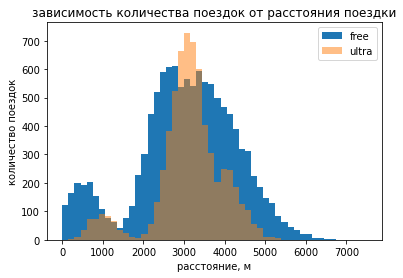

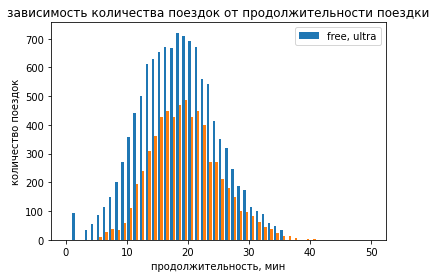

In [54]:
plt.hist(scooter_free['distance'],bins=50, range=(0,7500), label='free')
plt.hist(scooter_ultra['distance'],bins=50, range=(0,7500), alpha=0.5, label='ultra')
plt.legend(loc='upper right')
plt.title('зависимость количества поездок от расстояния поездки')
plt.xlabel('расстояние, м')
plt.ylabel('количество поездок')
plt.show(),
plt.hist([scooter_free['duration'], scooter_ultra['duration']],bins=50, range=(0,50), label=['free, ultra'])
plt.legend(loc='upper right')
plt.title('зависимость количества поездок от продолжительности поездки')
plt.xlabel('продолжительность, мин')
plt.ylabel('количество поездок')
plt.show()

In [55]:
scooter_free['distance'].describe()

count    11568.000000
mean      3044.992911
std       1246.174341
min          0.000000
25%       2366.000000
50%       3114.000000
75%       3905.000000
max       7211.000000
Name: distance, dtype: float64

In [56]:
scooter_ultra['distance'].describe()

count    6500.000000
mean     3114.949231
std       836.894838
min       244.000000
25%      2785.000000
50%      3148.000000
75%      3560.000000
max      5699.000000
Name: distance, dtype: float64

In [57]:
scooter_free['duration'].describe()

count    11568.000000
mean        17.890992
std          6.330250
min          1.000000
25%         13.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: duration, dtype: float64

In [58]:
scooter_ultra['duration'].describe()

count    6500.000000
mean       19.037692
std         5.577439
min         4.000000
25%        15.000000
50%        19.000000
75%        22.000000
max        41.000000
Name: duration, dtype: float64

**Вывод**

1. С помощью описательной статитики и графиков визуализации можем сказать что среднее и медианное расстояние поездок примерно одинаково у пользователей без подписки и с подпиской. Наблюдаем сокращение дальности поездки (5699 к 7211м) и среднего отклонения у пользователей с подпиской (836 к 1246). Также видим смещение 2-го распределения данных  у пользователей с подпиской в сторону увеличения продолжительности поездки (среднее значение в 1000м).
2. Длительность поездки по подписке отличается от поездки без подписки в максимально длинной поездке (до 40 мин). Также по подписке значения медианы превышают сравнительную медиану примерно на 6-7%.


#### Шаг 5. Подсчёт выручки

***5.1 Создаем датафрейм с данными о поездках на основе датафрейма scooter***

In [59]:
scooter_new = scooter.pivot_table(
    index=('user_id', 'month'), 
    values=('distance', 'duration', 'minute_price', 'start_ride_price', 'subscription_fee'), 
    aggfunc=({'distance':{'count', 'sum'},'duration':'sum', 'minute_price': 'mean', 'start_ride_price': 'mean', 'subscription_fee':'mean'}))
scooter_new.head(10)

distance        duration minute_price start_ride_price  \
                 count    sum      sum         mean             mean   
user_id month                                                          
1       1            2   7026       42            6                0   
        4            1    754        7            6                0   
        8            2   6722       46            6                0   
        10           2   5809       32            6                0   
        11           3   7002       56            6                0   
        12           2   6751       28            6                0   
2       3            3  10187       63            6                0   
        4            2   6163       40            6                0   
        6            1   3255       14            6                0   
        7            2   6779       48            6                0   

              subscription_fee  
                          mean  
user_id month                   
1       1                  199  
        4                  199  
        8                  199  
        10                 199  
        11                 199  
        12                 199  
2       3                  199  
        4                  199  
        6                  199  
        7                  199

***Округлил значение времени поездки в шаге 2 предобработка даннных***

In [60]:
#переименуем столбцы с двухэтажными названиями
scooter_new.columns = ['count', 'distance', 'duration', 'minute_price', 'start_ride_price','subscription_fee']
scooter_new.head()

count  distance  duration  minute_price  start_ride_price  \
user_id month                                                              
1       1          2      7026        42             6                 0   
        4          1       754         7             6                 0   
        8          2      6722        46             6                 0   
        10         2      5809        32             6                 0   
        11         3      7002        56             6                 0   

               subscription_fee  
user_id month                    
1       1                   199  
        4                   199  
        8                   199  
        10                  199  
        11                  199

In [61]:
scooter_new.isna().sum()

count               0
distance            0
duration            0
minute_price        0
start_ride_price    0
subscription_fee    0
dtype: int64

***5.2 В DF scooter_new добавим стобец с помесячной выручкой по каждому пользователю***

In [62]:
scooter_new['monthly_revenue'] = (scooter_new['start_ride_price']*scooter_new['count']+
                                  scooter_new['minute_price']*scooter_new['duration']+
                                  scooter_new['subscription_fee'])
scooter_new

count  distance  duration  minute_price  start_ride_price  \
user_id month                                                              
1       1          2      7026        42             6                 0   
        4          1       754         7             6                 0   
        8          2      6722        46             6                 0   
        10         2      5809        32             6                 0   
        11         3      7002        56             6                 0   
...              ...       ...       ...           ...               ...   
1534    6          2      3409        26             8                50   
        8          2      7621        48             8                50   
        9          1      4928        23             8                50   
        11         4     13349        78             8                50   
        12         1      2371        16             8                50   

               subscription_fee  monthly_revenue  
user_id month                                     
1       1                   199              451  
        4                   199              241  
        8                   199              475  
        10                  199              391  
        11                  199              535  
...                         ...              ...  
1534    6                     0              308  
        8                     0              484  
        9                     0              234  
        11                    0              824  
        12                    0              178  

[11331 rows x 7 columns]

In [63]:
print('Общая выручка:', scooter_new['monthly_revenue'].sum().round(0), 'руб')

Общая выручка: 3878641 руб


**Вывод**

В результате работы с новым датафреймом добавили столбец помесячной выручки каждого пользователя. Общая выручка компании составляет 3878641руб.

#### Шаг 6. Проверка гипотез

***6.1 Гипотеза 1 - тратят ли пользователи с подпиской больше времени на поездки чем пользователи без подписки***

In [64]:
# пропишем гипотезу: 
# H0 -  время использования самокатов по подписке равно времени использования без подписки
# H1 - время с подпиской больше чем без подписки
alpha = 0.05
results = st.ttest_ind(scooter_ultra['duration'], scooter_free['duration'], equal_var=False, alternative='greater')
print('р-значение', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

р-значение 1.1814679253701353e-36
Отвергаем нулевую гипотезу


Есть основание утверждать что средняя продолжительность поездок с подпиской больше чем без подписки, что так же подтверждается числовым описанием данных на гистограмме.

***6.2 Гипотеза 2 - среднее расстояние поездки по подписке не превышает 3130 метров***

In [65]:
# Расстояние одной поездки в 3130 метров - оптимальное с точки зрения износа самоката
# пропишем гипотезу: 
# H0 - среднее расстояние поездки по подписки равно 3130 метров
# H1 - среднее расстояние поездки по подписки больше 3130 метров
mean_distance = 3130
alpha = 0.05
results = st.ttest_1samp(scooter_ultra['distance'], mean_distance, alternative='greater')
print('р-значение', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

р-значение 0.9264356652998772
Не получилось отвергнуть нулевую гипотезу


Т.к. нулевая гипотеза не отвергнута, то утверждаем что среднее расстояние поездки пользователей с подпиской не превышает расстояние в 3130м, которое считается оптимальным с точки зрения износа.

***6.3 Гипотеза 3 - помесячная выручка пользователей с подпиской выше чем у пользователей без подписки***

In [66]:
# пропишем гипотезу: 
# H0 - средняя помесячная выручка пользователей с подпиской равна помесячной выручке пользователей без подписки
# H1 - средняя помесячная выручка пользователей с подпиской больше помесячной выручки пользователей без подписки
alpha = 0.05
results = st.ttest_ind(scooter_new.loc[scooter_new['subscription_fee']==199, 'monthly_revenue'], 
                       scooter_new.loc[scooter_new['subscription_fee']==0, 'monthly_revenue'], equal_var=False, alternative='greater')
print('р-значение', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

р-значение 8.874140893976874e-40
Отвергаем нулевую гипотезу


Основная гипотеза о равенстве выручки от подписчиков и пользователей без подписки отвергнута. Это дает возможность утверждать что выручка от подписки превышает выручку от пользователей без подписки.

***6.4 Гипотеза 4 - при обновлении сервера снизилось ли обращение в сервис***

Так как данные зависимы по времени между собой, то в первую очередь надо сравнить данные до и после обновления на соответствие данных (уникальных). Если данные не имеют различий то применяем метод scipy.stats.ttest_rel.
Если есть различия то используют метод scipy.stats.ttest_ind с параметрами equal_var=False (данные не одинаковы) и alternative=’less’ т.к. первая гипотеза отвергнута (обращений до обновления сервера было меньше).

**Вывод**

При проверки гипотез удалось установить:
1. Средняя продолжительность поездок с подпиской больше чем без подписки, что так же подтверждается числовым описанием данных на гистограмме.
2. Оптимальная дальность поездки для сервиса самокатов не превышает установленного значения в 3130 м для пользователей с подпиской (среднее значение в 3148 незначительно превышает медиану в 3114).
3. Нулевая гипотеза о равенстве выручки пользователей с подпиской и без не подтвердилась - можем сказать что выручка по подписки превышает выручку от пользователей без подписки.
4. После обновления сервера необходимо проверить данные на аналогичность, и в случае "зависимости" данных друг от друга использовать тест scipy.stats.ttest_rel, в противном случае использовать тест scipy.stats.ttest_ind.

**Общий вывод**

В процессе работы с данными сервиса аренды самокатов провели следующие работы:
    1. Загрузка данных
        - В первом датафрейме users_go 1565 строк, дубликатов 31, пропуски отсутствуют.
        - Во втором датафрейме rides_go 18068 строк, дубликатов нет, пропусков нет.
        - В третьем датафрейме subscriptions_go 2 строки, дубликатов и пропусков нет.
    Наименования столбцов не нуждаются в исправлении. Необходимо поменять тип данных для некоторых столбцов.
    
    2. Предобработка данных
        - Изменили тип в столбце date на datetime64, в столбце distance и duration на int.
        - Изменили типы данных в столбцах date, distance, duration. 
        - Создали столбец с номером месяца month на основе столбца date. 
        - Удалили дубликаты (31) в датафрейме users_go.
        
    3. Исследовательский анализ данных
        - Первое место по количеству поездок занимает курортный город Пятигорск(219), Екатеринбург на 2 месте(204), Москва на последнем месте (168).
        - Из общего числа пользователей сервиса аренды самокатов пользователей без подписки 54,4%, с подпиской 45,6%.
        - Среднее значение данных пользователей по возрасту близко к медиане и находится в районе 25 лет.
        - Большая часть поездок приходится на расстояния от 2500 до 3800м со средним значением в 3100м. Но на гистограмме отображена 2-я область с нормальным распределением значений в районе 650м.
        - Средняя продолжительность поездки 17 мин совпадает с медианой данных. Есть выбросы - поездки короткие в 1 мин.
   
    4. Объединение данных
        - Из созданных датафреймов делаем заключение - поездки по подписке меньше по расстоянию 5699 против 7211 м, а также и  среднего отклонения у пользователей с подпиской (836 к 1246). Во втором распределении данных у пользователей с подпиской имеется увеличение продолжительности поездки - среднее значение в 1000 м).
        - Продолжительность  поездки по подписке немного выше чем без подписки
            а. максимально длинная поездка  40 мин против 34 мин без подписки
            б. средняя продолжительность поездки и медиана по подписке 18, 18,03 против 17 и 16,89 без подписки соответственно (разница в 5-6%)
    
    5. Подсчет выручки 
    
        Общая выручка компании составляет 3878641 руб.
    
    6. Проверка гипотез
    
        - Нулевая гипотеза отвергнута. Средняя продолжительность поездок с подпиской (шаг 4.2.б) больше чем без подписки, что так же подтверждается числовым описанием данных на гистограмме.
        - Нулевая гипотеза не отвергнута, считаем что оптимальная дальность поездки для сервиса самокатов не превышает установленного значения в 3130 м для пользователей с подпиской (также подтверждается медианой 3114).
        - Нулевая гипотеза о равенстве выручки пользователей с подпиской и без не подтвердилась - можем сказать что выручка по подписки превышает выручку от пользователей без подписки.
        - При обновлении сервера с данными необходимо проверить данные на аналогичность, и в случае "зависимости" данных друг от друга нужно использовать тест scipy.stats.ttest_rel, в противном случае использовать тест scipy.stats.ttest_ind.
        
Резюме: 

Для сервиса аренды самокатов GoFast предпочтительнее развивать направление сдачи самокатов в аренду по подписке, т.к данные подтвердили превышение выручки от подписчиков над пользователями без подписки, несмотря на их большее количество (55%).
 